# Imports and Init

In [309]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import joblib
from sklearn.impute import SimpleImputer
import scipy.io as sio
from scipy.signal import savgol_filter
from scipy.io import savemat

import torch
import torch.nn as nn
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import torch.nn.functional as F


In [327]:
# Nutrient
from sklearn.metrics import r2_score
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import train_test_split

In [329]:
# Disease
from sklearn.metrics import f1_score

In [330]:
# Crop detection
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import recall_score

In [324]:
!pip install onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 65.8 MB/s eta 0:00:00


In [285]:
name = 'Indian_pines_corrected'

gtd = loadmat('Indian_pines_gt.mat')
htd = loadmat('Indian_pines_corrected.mat')
hsi = htd[list(htd.keys())[3]]
gt = gtd[list(gtd.keys())[3]]

print(hsi.shape)
print(gt.shape)

(145, 145, 200)
(145, 145)


In [252]:
def generate_dummy(hsi):
    dummy_hsi = np.random.rand(*hsi.shape).astype(np.float32)

    dummy_hsi[:, :, 50:60] *= 1.2
    dummy_hsi[:, :, 30:40] *= 0.8

    dummy_gt = np.random.randint(0, 5, size=(145, 145))

    #nans
    dummy_hsi[100:110, 50:60, :] = np.nan
    dummy_hsi[:, :, 150] = np.nan

    return dummy_hsi, dummy_gt

hsi_dummy, gt_dummy = generate_dummy(hsi)
savemat(f'dummy_{name}.mat',
        {'hsi': hsi_dummy, 'gt': gt_dummy})

In [186]:
gtd

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Fri May 20 18:25:41 2011',
 '__version__': '1.0',
 '__globals__': [],
 'indian_pines_gt': array([[3, 3, 3, ..., 0, 0, 0],
        [3, 3, 3, ..., 0, 0, 0],
        [3, 3, 3, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}

In [174]:
nir_band = 100   # ~850 nm
red_band = 50    # ~670 nm
lambda700 = 110
lambda670 = 50
lambda550 = 30
lambda531 = 25
lambda570 = 35

nir = hsi[:, :, nir_band]
red = hsi[:, :, red_band]

ndvi = (nir - red) / (nir + red)

In [256]:
pca_n_components = 40
wavelengths = np.linspace(400, 2500, hsi.shape[2])
raw_spectra = np.random.rand(hsi.shape[0]*hsi.shape[1], hsi.shape[2]).astype(np.float32)

In [299]:
unique_values, counts = np.unique(flat_gt, return_counts=True)
print(f"unique_values: {unique_values}")
print(f"counts: {counts}")

# Print the unique values and their counts
for value, count in zip(unique_values, counts):
    print(f"Value {value}: {count} occurrences")

unique_values: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
counts: [10776    46  1428   830   237   483   730    28   478    20   972  2455
   593   205  1265   386    93]
Value 0: 10776 occurrences
Value 1: 46 occurrences
Value 2: 1428 occurrences
Value 3: 830 occurrences
Value 4: 237 occurrences
Value 5: 483 occurrences
Value 6: 730 occurrences
Value 7: 28 occurrences
Value 8: 478 occurrences
Value 9: 20 occurrences
Value 10: 972 occurrences
Value 11: 2455 occurrences
Value 12: 593 occurrences
Value 13: 205 occurrences
Value 14: 1265 occurrences
Value 15: 386 occurrences
Value 16: 93 occurrences


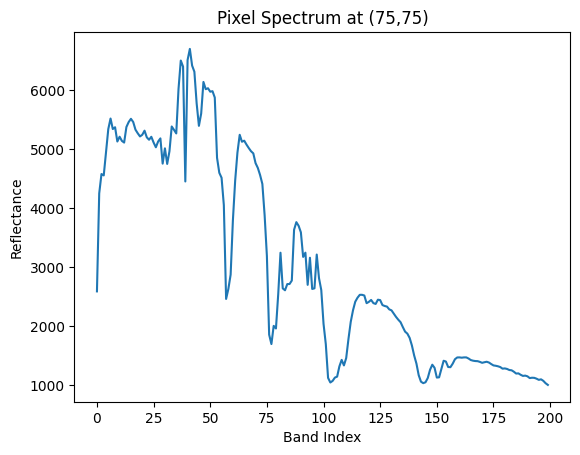

In [298]:
sample_spectrum = hsi[75, 75, :]

plt.plot(sample_spectrum)
plt.title("Pixel Spectrum at (75,75)")
plt.xlabel("Band Index")
plt.ylabel("Reflectance")
plt.show()


# Data Preprocessing

In [176]:
def apply_savgol(spectra):
    return savgol_filter(spectra, window_length=11, polyorder=2, axis=1, mode='nearest')

In [177]:
def log_transform(spectra):
    return np.log10(spectra + 1e-6)

## data loading

In [300]:
# hsi (H, W, C), gt (H, W)
H, W, C = hsi.shape
print(f"H: {H}, W: {W}, C: {C}")
flat_data = hsi.reshape(-1, C)
flat_gt = gt.reshape(-1)

print(f"Shape of flat_data: {flat_data.shape}")
print(f"Shape of flat_gt: {flat_gt.shape}")

train_mask = np.isin(flat_gt, [1, 2, 3]) # somewhat wrong
print(f"Train Mask: {train_mask} | Train Mask Shape : {train_mask.shape}")

X_train = flat_data[train_mask]
y_train = flat_gt[train_mask]
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")

test_mask = flat_gt == 0
X_new = flat_data[test_mask]
print(f"test mask: {test_mask.shape}")
print(f"X_new: {X_new.shape}")


H: 145, W: 145, C: 200
Shape of flat_data: (21025, 200)
Shape of flat_gt: (21025,)
Train Mask: [ True  True  True ... False False False] | Train Mask Shape : (21025,)
X_train: (2304, 200)
y_train: (2304,)
test mask: (21025,)
X_new: (10776, 200)


## scaling | processing | pca fit

In [301]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

pca = PCA(n_components=pca_n_components)
pca.fit_transform(X_train_scaled)

joblib.dump(pca, 'pca_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

pca = joblib.load('pca_model.pkl')
scaler = joblib.load('scaler.pkl')


## spectral preprocessor

In [303]:
class RobustSpectralPreprocessor:
    def __init__(self, pca_model_path='pca_model.pkl'):
        self.pca =joblib.load(pca_model_path)
        self.imputer = SimpleImputer(strategy='mean')  # NaN handler

    def _load_pca(self, path):
        return PCA(n_components=40)

    def process(self, raw_spectra):
        smoothed = savgol_filter(
            np.nan_to_num(raw_spectra),
            window_length=11,
            polyorder=2
        )
        print(f"smoothed shape: {smoothed.shape}")

        with np.errstate(invalid='ignore'):
            logged = np.log10(smoothed + 1e-6)
        print(f"logged shape: {logged.shape}")

        logged_clean = self.imputer.fit_transform(logged)
        print(f"logged_clean shape: {logged_clean.shape}")

        pca_reduced = self.pca.transform(logged_clean)
        print(f"pca_reduced shape: {pca_reduced.shape}")

        vis = self._calculate_vi(logged_clean)
        print(f"vis shape: {vis.shape}")

        return np.column_stack([pca_reduced, vis])

    def _calculate_vi(self, spectra):
        """NaN-safe vegetation index calculation"""
        red = spectra[:, 90]
        nir = spectra[:, 120]

        with np.errstate(divide='ignore', invalid='ignore'):
            ndvi = np.where(
                (nir + red) != 0,
                (nir - red) / (nir + red),
                0
            )
        return ndvi

## process data

In [302]:
# data = loadmat('dummy_indian_pines.mat')
# hsi, gt = data['hsi'], data['gt']

# Reshape(convert HSI cube to 2D)
n_pixels = 145 * 145
print(f"hsi shape: {hsi.shape}")
spectra = hsi.reshape(n_pixels, 200)  # Shape: (21025, 200)
print(f"spectra shape: {spectra.shape}")

# Process
preproc = RobustSpectralPreprocessor('pca_model.pkl')
processed = preproc.process(spectra)  # Output: (21025, 52)
print(f"preproc shape: {processed.shape}")

# Reshape back
processed_cube = processed.reshape(hsi.shape[0], hsi.shape[1], pca_n_components+1)

hsi shape: (145, 145, 200)
spectra shape: (21025, 200)
smoothed shape: (21025, 200)
logged shape: (21025, 200)
logged_clean shape: (21025, 200)
pca_reduced shape: (21025, 40)
vis shape: (21025,)
preproc shape: (21025, 41)


## test

In [296]:
def test_preprocessing():
    # hsi, _ = generate_dummy_indian_pines()
    spectra = hsi.reshape(-1, 200)
    print(f"spectra shape : {spectra.shape}")

    # Test 1: Handles cube-to-2D conversion
    preproc = RobustSpectralPreprocessor('pca_model.pkl')
    out = preproc.process(spectra)
    print(f"out shape : {out.shape}")
    assert out.shape == (hsi.shape[0]*hsi.shape[1], pca_n_components+1)

    # Test 2: Processes NaN bands correctly
    assert not np.isnan(out).any()

    # Test 3: Preserves spatial reconstructability
    out_cube = out.reshape(hsi.shape[0], hsi.shape[1], pca_n_components+1)
    # assert out_cube.shape == (145, 145, 41)

In [297]:
test_preprocessing()

spectra shape : (21025, 200)
smoothed shape: (21025, 200)
logged shape: (21025, 200)
logged_clean shape: (21025, 200)
pca_reduced shape: (21025, 40)
vis shape: (21025,)
out shape : (21025, 41)


# Feature Extraction

## spectralFeatureExtractor

In [305]:
class SpectralFeatureExtractor(nn.Module):
    def __init__(self, input_dim=52, conv_dim=64, nhead=4):
        super().__init__()
        # 1D-CNN for local spectral patterns
        self.conv = nn.Sequential(
            nn.Conv1d(input_dim, conv_dim, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2)
        )
        # Transformer for global dependencies
        self.transformer = TransformerEncoder(
            TransformerEncoderLayer(
                d_model=conv_dim,
                nhead=nhead,
                dim_feedforward=256,
                batch_first=True
            ),
            num_layers=2
        )

    def forward(self, x):
        # x shape: (batch, seq_len, features) -> (batch, 52, 145)
        x = x.permute(0, 2, 1)  # Conv1d expects (batch, channels, seq)
        x = self.conv(x)  # -> (batch, 64, 72)
        x = x.permute(0, 2, 1)  # -> (batch, 72, 64) for transformer
        return self.transformer(x)  # -> (batch, 72, 64)

# Multihead task Predictor

## Nutrient Head
- Regression

In [306]:
class NutrientHead(nn.Module):
    def __init__(self, input_dim=64):
        super().__init__()
        self.regressor = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 3)  # N, P, K values
        )

    def forward(self, x):
        # x: Transformer output (batch, seq, features)
        return self.regressor(x.mean(dim=1))  # Global avg pooling -> (batch, 3)

nutrient_loss = nn.HuberLoss(delta=1.0)

## Disease HEad
- Classification

In [308]:
class DiseaseHead(nn.Module):
    def __init__(self, input_dim=64, num_diseases=10):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, num_diseases)
        )
    def forward(self, x):
        return torch.sigmoid(self.classifier(x.mean(dim=1)))  # Multi-label

disease_loss = nn.BCELoss()

## Crop Identification
- Embedding

In [317]:
class CropEmbeddingHead(nn.Module):
    def __init__(self, input_dim=64, embed_dim=32):
        super().__init__()
        self.projection = nn.Linear(input_dim, embed_dim)

    def forward(self, x):
        # x: (batch, seq, features)
        return F.normalize(self.projection(x.mean(dim=1)), p=2.0, dim=1)  # L2-normalized

# Contrastive Loss (requires paired data)
crop_loss = nn.TripletMarginLoss(margin=1.0)  # anchor/positive/negative crops

# integrated Model

In [318]:
class AgriMultiTaskModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = SpectralFeatureExtractor()
        self.nutrient_head = NutrientHead()
        self.disease_head = DiseaseHead()
        self.crop_head = CropEmbeddingHead()

    def forward(self, x):
        features = self.backbone(x)
        return {
            'nutrients': self.nutrient_head(features),
            'diseases': self.disease_head(features),
            'embeddings': self.crop_head(features)
        }

# Training Script

In [319]:
model = AgriMultiTaskModel()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

def train_step(batch):
    spectra = batch['spectra']  # (batch, 52)
    targets = batch['targets']

    # Forward pass
    outputs = model(spectra)

    # Loss computation
    loss = (
        0.5 * nutrient_loss(outputs['nutrients'], targets['npk']) +
        0.3 * disease_loss(outputs['diseases'], targets['diseases']) +
        0.2 * crop_loss(
            outputs['embeddings'][::2],  # Anchors
            outputs['embeddings'][1::2], # Positives
            torch.roll(outputs['embeddings'], 1, dim=0)[::2]  # Negatives
        )
    )

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item()

# Deployment

## Edge devices

In [322]:
scripted_model = torch.jit.script(model)

quantized_model = torch.quantization.quantize_dynamic(
    scripted_model, {nn.Linear}, dtype=torch.qint8
)

torch.jit.save(quantized_model, "agri_model.pt")

## 5G-ONNX Export

In [325]:
dummy_input = torch.randn(1, 145, 52)  # Batch, seq_len, features
torch.onnx.export(
    model,
    dummy_input,
    "agri_model.onnx",
    input_names=["spectra"],
    output_names=["nutrients", "diseases", "embeddings"]
)

# Scoring

## Neutrient Score (R-squared)

In [ ]:
# Assuming preprocessed data:
# X: (n_samples, 52) - Preprocessed features
# y_nutrients: (n_samples, 3) - NPK values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_nutrients, test_size=0.2)

# 1D-CNN + PLSR Pipeline
pls = PLSRegression(n_components=10)
pls.fit(X_train, y_train)

# Predict and calculate R²
y_pred = pls.predict(X_test)
r2 = r2_score(y_test, y_pred, multioutput='uniform_average')  # Average across N/P/K

print(f"R² Score: {r2:.3f}")

## Disease (F1)

In [ ]:
from transformers import TransformerClassifier

# y_diseases: (n_samples, n_diseases) - Multi-hot encoded labels

class TransformerClassifier(nn.Module):
    def __init__(self, input_dim=52):
        super().__init__()
        self.encoder = TransformerEncoderLayer(d_model=input_dim, nhead=4)
        self.classifier = nn.Linear(input_dim, 10)

    def forward(self, x):
        return torch.sigmoid(self.encoder(x).mean(dim=1))

# Training loop (PyTorch)
model = TransformerClassifier()
optimizer = torch.optim.Adam(model.parameters())

for epoch in range(10):
    outputs = model(X_train_tensor)
    loss = nn.BCELoss()(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

# Threshold predictions at 0.5
y_pred = (model(X_test_tensor).detach().numpy() > 0.5).astype(int)
f1 = f1_score(y_test, y_pred, average='macro')  # Macro-average for class imbalance

print(f"F1 Score: {f1:.3f}")

## Crop (recall k)

In [ ]:
# embeddings: (n_samples, 32) - From contrastive head
# y_crop: (n_samples,) - Crop type labels

# Fit KNN on training embeddings
knn = NearestNeighbors(n_neighbors=5).fit(X_train_embeddings)

# For each test sample, find 5 nearest neighbors
_, indices = knn.kneighbors(X_test_embeddings)
pred_labels = y_train[indices.flatten()].reshape(-1, 5)

# Calculate if true label is in top-k
recall_at_5 = np.mean([true in pred for true, pred in zip(y_test, pred_labels)])

print(f"Recall@5: {recall_at_5:.1%}")

## Evaluate Model

In [ ]:
def evaluate_model(model, X_test, y_test_nutrients, y_test_diseases, y_test_crops):
    # Get all predictions
    outputs = model(X_test)

    # Nutrient R²
    r2 = r2_score(y_test_nutrients, outputs['nutrients'].detach().numpy())

    # Disease F1
    disease_pred = (outputs['diseases'].detach().numpy() > 0.5).astype(int)
    f1 = f1_score(y_test_diseases, disease_pred, average='macro')

    # Crop Recall@5
    knn = NearestNeighbors(n_neighbors=5).fit(training_embeddings)
    _, indices = knn.kneighbors(outputs['embeddings'].detach().numpy())
    recall = np.mean([y_test_crops[i] in y_train_crops[indices[i]] for i in range(len(y_test_crops))])

    return {'r2': r2, 'f1': f1, 'recall@5': recall}

## Confidence Interval via bootstraping

In [ ]:
from sklearn.utils import resample
r2_scores = [r2_score(*resample(y_test, y_pred)) for _ in range(1000)]
print(f"R² CI: {np.percentile(r2_scores, [2.5, 97.5])}")